# Capítulo 4 - Treinando Modelos

Este notebook contém os exemplos de código e soluções para os exercícios do capítulo 4 do livro "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow".

## A Equação Normal

A Equação Normal é uma fórmula matemática que nos dá diretamente o resultado para encontrar o valor de $\theta$ (os parâmetros do modelo) que minimiza a função de custo do Erro Quadrático Médio (MSE). É uma solução de forma fechada, o que significa que não precisamos de um processo iterativo como o Gradiente Descendente para encontrar os melhores parâmetros.

A equação é:

$$ \hat{\theta} = (X^T X)^{-1} X^T y $$

Onde:
- $\hat{\theta}$ é o valor de $\theta$ que minimiza a função de custo.
- $y$ é o vetor de valores alvo.
- $X$ é a matriz de características (features).

Primeiro, vamos gerar alguns dados com aparência linear para testar a equação.

In [1]:
import numpy as np

np.random.seed(42) # Para garantir que o código seja reprodutível
m = 100 # Número de instâncias
X = 2 * np.random.rand(m, 1) # Vetor coluna com as características
y = 4 + 3 * X + np.random.randn(m, 1) # Vetor coluna com os alvos + ruído gaussiano

Agora, vamos calcular $\hat{\theta}$ usando a Equação Normal. Usaremos a função `inv()` do módulo de álgebra linear do NumPy (`np.linalg`) para calcular a inversa de uma matriz e o método `dot()` ou o operador `@` para multiplicação de matrizes.

**Nota:** A Equação Normal calcula o $\theta_0$ (termo de interceptação ou bias) e os outros pesos das características ($\	heta_1, \theta_2, ..., \theta_n$). Para que a equação funcione, precisamos adicionar uma característica $x_0 = 1$ a cada instância. A função `add_dummy_feature` do Scikit-Learn faz exatamente isso.

In [2]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # Adiciona x0 = 1 para cada instância
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

A função que usamos para gerar os dados foi $y = 4 + 3x_1 + \text{ruído}$. Vamos ver o que a equação encontrou para $\theta_0$ e $\theta_1$.

In [3]:
theta_best

array([[4.21509616],
       [2.77011339]])

O resultado foi $\theta_0 \approx 4.215$ e $\theta_1 \approx 2.770$. Esperávamos $\theta_0 = 4$ e $\theta_1 = 3$. O resultado está próximo, mas o ruído que adicionamos aos dados tornou impossível recuperar os parâmetros exatos da função original.

Agora podemos fazer previsões usando o $\hat{\theta}$ que encontramos.

In [4]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # Adiciona x0 = 1 para cada instância
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

Vamos plotar as previsões do nosso modelo.

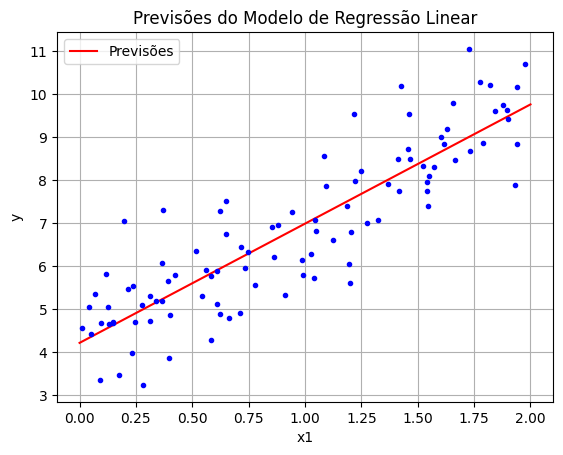

In [5]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-", label="Previsões")
plt.plot(X, y, "b.")
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Previsões do Modelo de Regressão Linear")
plt.legend()
plt.grid(True)
plt.show()

### Usando Scikit-Learn

Fazer regressão linear com o Scikit-Learn é bem mais simples. Note que a biblioteca separa o termo de bias (`intercept_`) dos pesos das características (`coef_`).

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [7]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

A classe `LinearRegression` é baseada na função `scipy.linalg.lstsq()` (least squares - mínimos quadrados), que você pode chamar diretamente.

Esta função calcula $\hat{\theta} = X^+y$, onde $X^+$ é a **pseudoinversa** de $X$. A pseudoinversa é mais geral que a inversa e é calculada usando uma técnica chamada Decomposição de Valor Singular (SVD). Essa abordagem é mais eficiente e robusta que a Equação Normal, pois a Equação Normal pode não funcionar se a matriz $X^T X$ não for invertível (singular), como quando o número de características é maior que o número de instâncias, ou quando algumas características são redundantes. A pseudoinversa, por outro lado, está sempre definida.

In [8]:
# Usando a função lstsq do numpy
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [9]:
# Usando a pseudoinversa diretamente
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

## Gradiente Descendente (Gradient Descent)

O Gradiente Descendente é um algoritmo de otimização genérico usado para encontrar soluções ótimas para uma vasta gama de problemas. A ideia principal é ajustar os parâmetros de forma iterativa para minimizar uma função de custo.

Ele funciona medindo o gradiente local da função de erro em relação ao vetor de parâmetros $\theta$ e indo na direção oposta (descendente) desse gradiente. Quando o gradiente é zero, atingimos um mínimo.

Um parâmetro importante é a **taxa de aprendizado** (*learning rate*), que determina o tamanho de cada passo. 
- Se for **muito pequena**, o algoritmo levará muito tempo para convergir.
- Se for **muito alta**, pode pular o mínimo e divergir, nunca encontrando uma boa solução.

### Gradiente Descendente em Lote (Batch Gradient Descent)

No Batch Gradient Descent, calculamos os gradientes usando **todo o conjunto de treinamento** a cada passo. Isso o torna muito lento em conjuntos de dados grandes.

O vetor de gradiente da função de custo MSE é dado por:

$$ \nabla_{\theta} \text{MSE}(\theta) = \frac{2}{m} X^T (X\theta - y) $$

E o passo do Gradiente Descendente é:

$$ \theta^{(\text{próximo passo})} = \theta - \eta \nabla_{\theta} \text{MSE}(\theta) $$

Onde $\eta$ é a taxa de aprendizado.

In [10]:
eta = 0.1  # Taxa de aprendizado
n_epochs = 1000
m = len(X_b)  # Número de instâncias

np.random.seed(42)
theta = np.random.randn(2, 1)  # Inicialização aleatória dos parâmetros

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

Vamos verificar o `theta` resultante.

In [11]:
theta

array([[4.21509616],
       [2.77011339]])

Exatamente o que a Equação Normal encontrou! O Gradiente Descendente funcionou perfeitamente.

### Gradiente Descendente Estocástico (Stochastic Gradient Descent - SGD)

O principal problema do Batch GD é que ele usa todo o conjunto de treinamento a cada passo, tornando-o lento. O SGD resolve isso pegando uma **instância aleatória** do conjunto de treinamento a cada passo e calculando os gradientes com base apenas nela. 

**Vantagens:**
- **Muito mais rápido**, pois manipula poucos dados por iteração.
- Pode treinar em conjuntos de dados enormes.

**Desvantagens:**
- É muito menos regular (estocástico). A função de custo saltará para cima e para baixo, diminuindo apenas na média. 
- Nunca se estabiliza no mínimo, continuando a saltar ao redor dele.

A natureza aleatória do SGD é boa para escapar de mínimos locais, mas ruim porque nunca se estabiliza. Uma solução é reduzir gradualmente a taxa de aprendizado. Isso é chamado de **agendamento de aprendizado** (*learning schedule*).

In [12]:
n_epochs = 50
t0, t1 = 5, 50  # Hiperparâmetros do agendamento de aprendizado

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # Inicialização aleatória

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        # Para o SGD, não dividimos por m, pois estamos usando uma única instância
        gradients = 2 * xi.T @ (xi @ theta - yi) 
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients

In [13]:
theta

array([[4.21076011],
       [2.74856079]])

O resultado é muito próximo do obtido com a Equação Normal, mas usando um método muito mais rápido e escalável.

### Usando Scikit-Learn para SGD

Para fazer regressão linear usando SGD com o Scikit-Learn, você pode usar a classe `SGDRegressor`, que por padrão otimiza a função de custo MSE.

In [14]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
# y.ravel() é usado porque fit() espera alvos 1D
sgd_reg.fit(X, y.ravel()) 

,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Regressão Polinomial

E se seus dados forem mais complexos que uma linha reta? Surpreendentemente, você pode usar um modelo linear para ajustar dados não lineares. Uma maneira simples de fazer isso é adicionar potências de cada característica como novas características e, em seguida, treinar um modelo linear neste conjunto estendido de características. Essa técnica é chamada de **Regressão Polinomial**.

Vamos gerar alguns dados não lineares, baseados em uma equação quadrática simples ($y = ax^2 + bx + c$).

In [16]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

Claramente, uma linha reta não se ajustará bem a esses dados. Então, vamos usar a classe `PolynomialFeatures` do Scikit-Learn para transformar nossos dados de treinamento, adicionando o quadrado (polinômio de segundo grau) de cada característica como uma nova característica.

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [18]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` agora contém a característica original de `X` mais o quadrado dessa característica. Agora podemos ajustar um modelo `LinearRegression` a esses dados de treinamento estendidos.

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

O modelo estima $\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78$, que é bem próximo da função original $y = 0.5x_1^2 + 1.0x_1 + 2.0$.

## Curvas de Aprendizado

As curvas de aprendizado são gráficos do desempenho de um modelo nos conjuntos de treinamento e validação como uma função do tamanho do conjunto de treinamento. Elas são uma ferramenta importante para diagnosticar problemas como **subajuste (underfitting)** e **sobreajuste (overfitting)**.

- **Subajuste (Underfitting):** Se o modelo tem um desempenho ruim tanto no conjunto de treinamento quanto no de validação, ele está subajustando. As curvas de erro para ambos os conjuntos atingem um platô, são altas e muito próximas uma da outra.
- **Sobreajuste (Overfitting):** Se o modelo tem um desempenho muito melhor no conjunto de treinamento do que no de validação, ele está sobreajustando. Há uma grande lacuna (gap) entre as curvas de aprendizado.

Vamos olhar as curvas de aprendizado de um modelo de regressão linear simples (que subajustará nossos dados quadráticos).

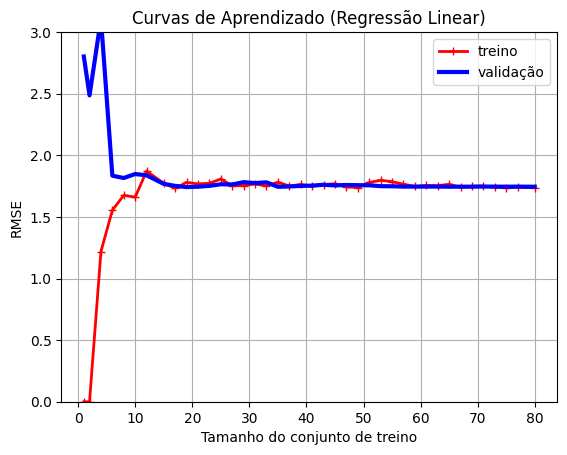

In [20]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="treino")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="validação")
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("RMSE")
plt.title("Curvas de Aprendizado (Regressão Linear)")
plt.legend()
plt.grid(True)
plt.ylim(0, 3)
plt.show()

Essas curvas são típicas de um modelo que está **subajustando**. Ambas as curvas atingem um platô; elas são altas e muito próximas uma da outra.

Agora, vamos ver as curvas de aprendizado de um modelo polinomial de 10º grau nos mesmos dados. Este modelo será muito flexível e provavelmente sobreajustará os dados.

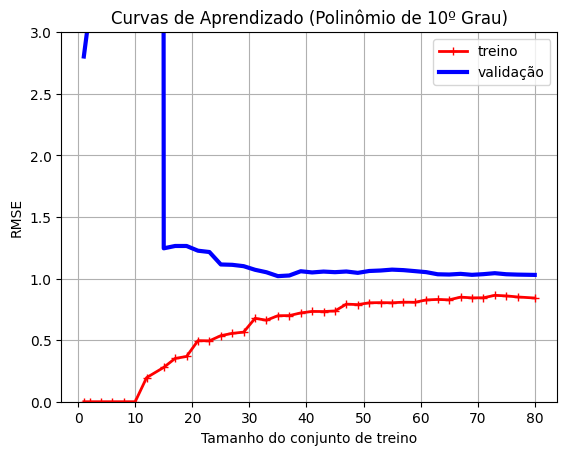

In [21]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="treino")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="validação")
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("RMSE")
plt.title("Curvas de Aprendizado (Polinômio de 10º Grau)")
plt.legend()
plt.grid(True)
plt.ylim(0, 3)
plt.show()

Aqui podemos ver duas diferenças importantes:
1. O erro nos dados de treinamento é muito menor do que com o modelo de regressão linear.
2. Existe uma lacuna (gap) entre as curvas. Isso significa que o modelo tem um desempenho significativamente melhor nos dados de treinamento do que nos de validação, o que é a marca registrada de um modelo com **sobreajuste (overfitting)**.

## Modelos Lineares Regularizados

Uma boa maneira de reduzir o sobreajuste é regularizar o modelo (ou seja, restringi-lo). Quanto menos graus de liberdade ele tiver, mais difícil será para ele sobreajustar os dados. Para um modelo polinomial, uma maneira simples de regularizar é reduzir o número de graus polinomiais. Para modelos lineares, a regularização é tipicamente alcançada restringindo os pesos do modelo.

### Regressão de Ridge

A Regressão de Ridge é uma versão regularizada da Regressão Linear: um termo de regularização igual a $\alpha \frac{1}{m} \sum_{i=1}^{n} \theta_i^2$ é adicionado à função de custo MSE. Isso força o algoritmo de aprendizado não apenas a ajustar os dados, mas também a manter os pesos do modelo o menor possível.

- O hiperparâmetro $\alpha$ controla o quanto você quer regularizar o modelo.
- Se $\alpha = 0$, a Regressão de Ridge é apenas Regressão Linear.
- Se $\alpha$ for muito grande, todos os pesos acabam muito próximos de zero.

**Importante:** É crucial escalar os dados (por exemplo, usando um `StandardScaler`) antes de realizar a Regressão de Ridge, pois ela é sensível à escala das características de entrada.

A Regressão de Ridge também possui uma solução de forma fechada:

$$ \hat{\theta} = (X^T X + \alpha A)^{-1} X^T y $$

Onde $A$ é a matriz identidade, com um 0 no canto superior esquerdo (correspondente ao termo de bias, que não é regularizado).

In [22]:
# Usando Scikit-Learn com solução de forma fechada ('cholesky')
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([4.82899748])

In [23]:
# Usando Gradiente Descendente Estocástico
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.82830117])

O hiperparâmetro `penalty` define o tipo de termo de regularização a ser usado. `"l2"` indica que você quer que o SGD adicione um termo de regularização à função de custo igual a alpha vezes o quadrado da norma $\ell_2$ do vetor de pesos, que é exatamente o que a Regressão de Ridge faz.

### Regressão Lasso

A Regressão Lasso (Least Absolute Shrinkage and Selection Operator Regression) é outra versão regularizada da Regressão Linear. Assim como a Ridge, ela adiciona um termo de regularização à função de custo, mas usa a **norma $\ell_1$** do vetor de pesos em vez do quadrado da norma $\ell_2$.

$$ J(\theta) = \text{MSE}(\theta) + 2\alpha \sum_{i=1}^{n} |\theta_i| $$

Uma característica importante da Regressão Lasso é que ela tende a eliminar completamente os pesos das características menos importantes (ou seja, defini-los como zero). Em outras palavras, a Lasso realiza automaticamente a **seleção de características**.

In [24]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

### Elastic Net

A Elastic Net é um meio-termo entre a Regressão de Ridge e a Lasso. O termo de regularização é uma soma ponderada dos termos de regularização da Ridge e da Lasso, e você pode controlar a proporção da mistura, $r$.

$$ J(\theta) = \text{MSE}(\theta) + r (2\alpha \sum_{i=1}^{n} |\theta_i|) + (1-r)(\alpha \frac{1}{m} \sum_{i=1}^{n} \theta_i^2) $$

- Quando $r=0$, a Elastic Net é equivalente à Regressão de Ridge.
- Quando $r=1$, é equivalente à Regressão Lasso.

**Quando usar qual?**
- É quase sempre preferível ter pelo menos um pouco de regularização, então geralmente você deve evitar a Regressão Linear simples.
- **Ridge** é um bom padrão.
- Se você suspeita que apenas algumas características são úteis, prefira **Lasso** ou **Elastic Net**, pois eles tendem a zerar os pesos das características inúteis.
- Em geral, **Elastic Net é preferível ao Lasso**, porque o Lasso pode se comportar de forma errática quando o número de características é maior que o número de instâncias de treinamento ou quando várias características estão fortemente correlacionadas.

In [25]:
from sklearn.linear_model import ElasticNet

# l1_ratio corresponde à proporção de mistura r
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

### Parada Antecipada (Early Stopping)

Uma maneira muito diferente de regularizar algoritmos de aprendizado iterativos, como o Gradiente Descendente, é **parar o treinamento assim que o erro de validação atinge um mínimo**. Isso é chamado de *early stopping*.

À medida que as épocas passam, o erro do algoritmo no conjunto de treinamento diminui, assim como seu erro no conjunto de validação. No entanto, depois de um tempo, o erro de validação para de diminuir e começa a subir. Isso indica que o modelo começou a sobreajustar os dados de treinamento. Com a parada antecipada, você simplesmente para o treinamento assim que o erro de validação atinge o mínimo.

A seguir, uma implementação básica.

In [ ]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Dividindo os dados quadráticos em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline para adicionar features polinomiais e escalar
preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)

n_epochs = 500
best_valid_rmse = float('inf')
best_model = None

for epoch in range(n_epochs):
    # partial_fit() é usado para aprendizado incremental
    sgd_reg.partial_fit(X_train_prep, y_train.ravel()) 
    
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    # Calculando RMSE manualmente: sqrt(MSE)
    mse = mean_squared_error(y_valid, y_valid_predict)
    val_error = np.sqrt(mse)  # RMSE
    
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        # deepcopy copia tanto os hiperparâmetros quanto os parâmetros aprendidos
        best_model = deepcopy(sgd_reg)

print(f"Melhor RMSE de validação: {best_valid_rmse}")

Melhor RMSE de validação: 0.7774374754877695


: 